# The N-Body Problem#

by Julián Ramón Marrades Furquet <br>
Department of Data Science and Knowledge Engineering <br>
Maastricht University

## What is the (N) Three-Body Problem?##
According to Wikipedia, in physics and classical mechanics, the three-body problem is the problem of taking the initial positions and velocities (or momenta) of three point masses and solving for their subsequent motion according to Newton's laws of motion and Newton's law of universal gravitation. <br>
The three-body problem is a special case of the n-body problem. Unlike two-body problems, no closed-form solution exists for all sets of initial conditions, and numerical methods are generally required.

## Formal definition ##
Our startpoint is the **Newton's law of universal gravitation**, which states that 2 bodies with masses $m_1$ and $m_2$ attract each other with a force:

$$F = -G \cdot \frac{m_1 \cdot m_2}{\left| \vec{r} \right| ^{\ 2}}$$

where $\vec{r}$ is a vector connection their center of mass, and $G$ is the gravitational constant, which we normalize to a value of $1$.

Now, we are interested in the acceleration which a body suffers when it is attracted by other masses, because it is the second derivative of its displacement. Therefore, we can use it to describe our system. <br>
For instance, we can state the acceleration of the body with $m_1$ when it is attracted by $m_2$ employing Newton's equations:

$$a_1 = \frac{F_1}{m_1} = -G \cdot \frac{m_2}{\left| \vec{r} \right| ^{\ 2}}$$

Since we are normalizing $G$, we can simplify the equation to:

$$a_1 = - \frac{m_2}{\left| \vec{r} \right| ^ {\ 2}}$$

If $m_1$ was part of a system of $n$ bodies, we could perform vector sum to express its overall acceleration caused by the attraction of the other $n-1$ masses:

$$a_1 = - \frac{m_2}{\left| \vec{r}_{12} \right| ^{\ 2}} - \frac{m_3}{\left| \vec{r}_{13} \right| ^{\ 2}} - \dots - \frac{m_n}{\left| \vec{r}_{1n} \right| ^{\ 2}}$$

## Building the system ##
To build our system we will perform two simple steps:
1. Obtain the modulus of the acceleration that a body suffers
2. Point it towards the correct direction (i.e. vectorize it)

#### 1. Obtaining the modulus ####

We can define the modulus of the acceleration that $m_1$ suffers when attracted by $m_2$ as:

$$a_1 = - \frac{m_2}{\left| \vec{r}_{12} \right| ^2}$$

#### 2. Vectorization of the modulus ####

Due to the negative sign of the previous equation, we need a unit vector pointing from $m_2$ to $m_1$, so that it is inverted and scaled afterwards. We can do it as follows:

$$\vec{v} = \frac{\vec{r}_1 - \vec{r}_2}{\vert \vec{r}_1 - \vec{r}_2 \vert}$$

Now it is time to bring the two previous equations together.

First, let's redefine $\left| \vec{r}_{12} \right|^2$:

$$\vec{r}_{12} = \vec{r}_1 - \vec{r}_2 \rightarrow \left| \vec{r}_{12} \right| ^2 = \vert \vec{r}_1 - \vec{p}_2 \vert ^ 2$$

Then, we bring the equations together and rearrange the terms:

$$\vec{a_1} = - \frac{m_2}{\vert p_1 - p_2 \vert^2} \frac{p_1 - p_2}{\vert p_1 - p_2 \vert} = - m_2 \frac{p_1 - p_2}{\vert p_1 - p_2 \vert^3}$$

Generalizing, if $m_1$ was attracted by more bodies:

$$\vec{a_1} = - m_2 \frac{\vec{r}_1 - \vec{r}_2}{\vert \vec{r}_1 - \vec{r}_2 \vert^3} - m_3 \frac{\vec{r}_1 - \vec{r}_3}{\vert \vec{r}_1 - \vec{r}_3 \vert^3} - \dots$$

However, we will limit ourselves to 3 masses (by now). Hence, since the acceleration is the second derivative of the displacement (or position), we can generate a system of 3 (9 due to 3D vectors) second order differential equations to describe the interactions of 3 bodies:

$$\ddot{r}_1 = - m_2 \frac{r_1 - r_2}{\vert r_1 - r_2 \vert^3} - m_3 \frac{r_1 - r_3}{\vert r_1 - r_3 \vert^3}$$

$$\ddot{r}_2 = - m_1 \frac{r_2 - r_1}{\vert r_2 - r_1 \vert^3} - m_3 \frac{r_2 - r_3}{\vert r_2 - r_3 \vert^3}$$

$$\ddot{r}_3 = - m_1 \frac{r_3 - r_1}{\vert r_3 - r_1 \vert^3} - m_2 \frac{r_3 - r_2}{\vert r_3 - r_2 \vert^3}$$

Note that the vector arrows of $\vec{r}$ is ommited for simplification.

## Implementation ##

Since we are working with ODE solvers within the `scipy` library, we need to transform this into a system of 6 (18 due to 3D vectors) ordinary differential equations.

We will use $y$ as our state vector such that
$$y = [r_1, r_2, r_3, \dot{r}_1, \dot{r}_2, \dot{r}_3]$$
Hence,
$$\dot{y} = [\dot{r}_1, \dot{r}_2, \dot{r}_3, \ddot{r}_1, \ddot{r}_2, \ddot{r}_3]$$

**Note:** every element of the vectors is a vector itself, representing the 3 spatial coordinates.

---
Let's start by importing everything we will need during the process

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
%matplotlib notebook

Now, we can define a function which returns $\dot{y}$ given $y$

In [2]:
def dydt(y, t, d, n, masses):
    """Returns the derivative of the state vector for the n-body problem.
    
    Keyword arguments:
    y -- state vector (flattened, so it includes d*2n elements --> components of position and velocity)
    t -- actual time of the system
    d -- number of spatial dimensions of the system
    n -- number of masses in the system
    masses -- arraylike containing the masses of the n bodies
    """
    
    # Define velocities for masses
    velocities = y[d*n:]
    
    # Define acceleration fo|r masses
    positions = np.reshape(y[:d*n], (n, d))
    accelerations = np.zeros((n, d))
    for i, acc in enumerate(accelerations):
        for j, pos in enumerate(positions):
            if i != j:
                diff_vector = positions[i] - pos
                acc -= masses[j] * (diff_vector / (np.linalg.norm(diff_vector)**3)) 
    
    # Return the derivative of the state vector
    return np.concatenate((velocities, accelerations.flatten()))

Define `y0`, `t` and `args` for `odeint`

In [6]:
t = np.linspace(0, 400, num=1000)

d, n = 3, 3
masses = np.array([1.5, 2, 5])
extra_args = (d, n, masses)

y0 = np.array([[20, 0, 0], [-17, 2, -4], [1, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0]]).flatten()

In [7]:
y = odeint(dydt, y0, t, args=extra_args)

<IPython.core.display.Javascript object>


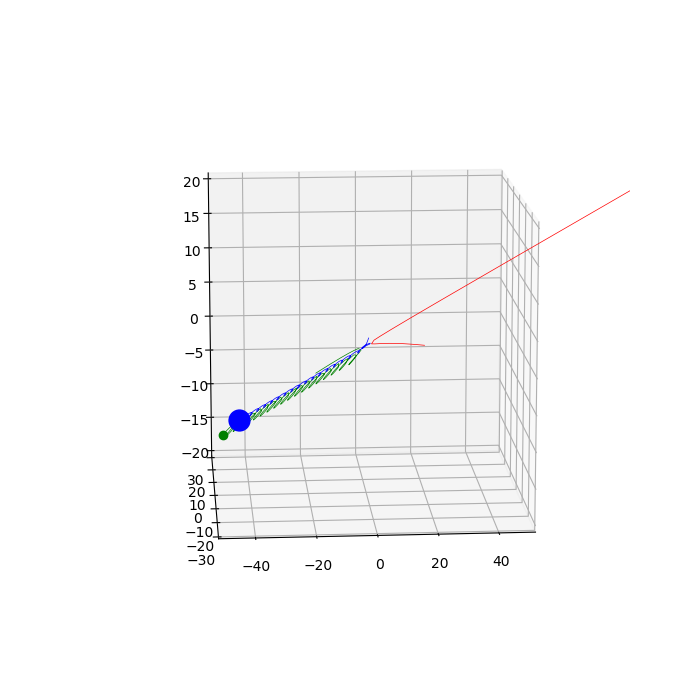

In [8]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-50, 50)
ax.set_ylim(-30, 30)
ax.set_zlim(-20, 20)

planet_base_size = 3

line1 = ax.plot([], [], [], '-', lw=0.5, color='r')[0]
planet1 = ax.plot([], [], [], marker='o', color='r', markersize=masses[0]*planet_base_size)[0]
line2 = ax.plot([], [], [], '-', lw=0.5, color='g')[0]
planet2 = ax.plot([], [], [], marker='o', color='g', markersize=masses[1]*planet_base_size)[0]
line3 = ax.plot([], [], [], '-', lw=0.5, color='b')[0]
planet3 = ax.plot([], [], [], marker='o', color='b', markersize=masses[2]*planet_base_size)[0]
lines = [line1, line2, line3, planet1, planet2, planet3]

# Animation function
def animate(i):
    for index, line in enumerate(lines[:3]):
        start_index = index*3
        line.set_data(y[:i+1, start_index], y[:i+1, start_index+1])
        line.set_3d_properties(y[:i+1, start_index+2])
    for index, planet in enumerate(lines[3:]):
        start_index = index*3
        planet.set_data(y[i, start_index], y[i, start_index+1])
        planet.set_3d_properties(y[i, start_index+2])
    return lines
    
anim = animation.FuncAnimation(fig, animate, frames=len(y), interval=8, blit=True)

plt.show()

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
#anim.save('lines.mp4', writer=writer)